In [1]:
%load_ext autoreload
%autoreload 2

from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

os.chdir('../')
from src import my_models as models
from src import model_analysis

In [2]:
os.getcwd()

'/home/maureen/Documents/Galvanize/Capstone1/Capstone3/Cancer_Prediction'

## FastAI on Histology Data

data/Histology/40X/train_fastAI
data/Histology/40X/train_fastAI ['benign', 'malignant']
benign


malignant


epoch,train_loss,valid_loss,error_rate,time
0,0.841082,0.351116,0.134078,03:10
1,0.586697,0.278099,0.094972,03:11
2,0.447087,0.197255,0.086592,03:07
3,0.363360,0.193665,0.086592,03:07


data/Histology/100X/train_fastAI
data/Histology/100X/train_fastAI ['benign', 'malignant']
benign


malignant


epoch,train_loss,valid_loss,error_rate,time
0,0.846907,0.357954,0.120000,03:27
1,0.617189,0.339046,0.109333,03:16
2,0.512244,0.270682,0.093333,03:10
3,0.413196,0.261565,0.096000,03:11


data/Histology/200X/train_fastAI
data/Histology/200X/train_fastAI ['benign', 'malignant']
benign


malignant


epoch,train_loss,valid_loss,error_rate,time
0,0.842022,0.295727,0.120219,03:01
1,0.641523,0.220955,0.092896,03:01
2,0.504634,0.251257,0.112022,03:02
3,0.412084,0.216822,0.095628,03:02


data/Histology/400X/train_fastAI
data/Histology/400X/train_fastAI ['benign', 'malignant']
benign


malignant


epoch,train_loss,valid_loss,error_rate,time
0,0.883206,0.395247,0.123494,02:43
1,0.705118,0.319092,0.105422,02:44
2,0.561946,0.248376,0.063253,02:44
3,0.461965,0.242107,0.069277,02:44


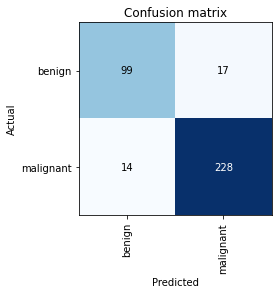

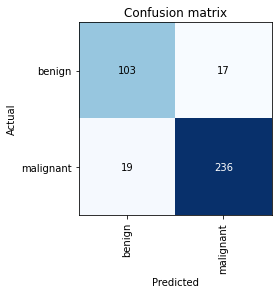

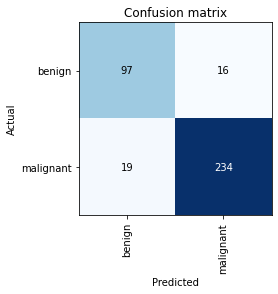

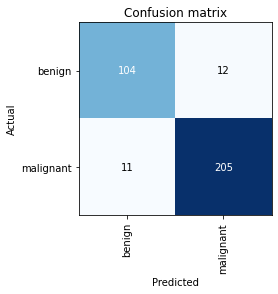

In [61]:
# Run on Histology data
mag = ['40X', '100X','200X', '400X']
filenames = []
predictions_all = []

def get_predictions(path, model):
    image_names = [f for f in os.listdir(path)]
    image_paths = [os.path.join(path,f) for f in os.listdir(path)]
    predictions = [model.predict_image(img) for img in image_paths]
 
    return image_names, predictions

for m in mag:
    train_path = f'data/Histology/{m}/train_fastAI'
    test_path = f'data/Histology/{m}/test/test'
    print(train_path)
    
    model = models.FastAI(train_path)
    print(model.path, model.classes)
    
    model.verify_images(500)
    model.fit(f'fastai_{m}')    
    
    # Val Metrics
    model.confusion_matrix()
    
    # Test predictions
    image_paths, predictions = get_predictions(test_path, model)
    predictions_all.append(predictions)
    filenames.append(image_paths)


In [126]:
len(master_labels[0])

201

In [124]:
# Get class labels from test set using filenames
master_labels = []
for file_list in filenames:
    labels = []
    for f in file_list:
        if 'SOB_B' in f:
            labels.append(0)
        else:
            labels.append(1)
    master_labels.append(labels)  
    
# Check    
for f, l in zip(filenames[0],master_labels[0]):
    print(f,l)

data/Histology/40X/test/test/SOB_M_DC-14-13412-40-029.png 1
data/Histology/40X/test/test/SOB_M_LC-14-16196-40-013.png 1
data/Histology/40X/test/test/SOB_M_DC-14-2523-40-013.png 1
data/Histology/40X/test/test/SOB_M_DC-14-17614-40-011.png 1
data/Histology/40X/test/test/SOB_M_DC-14-17614-40-013.png 1
data/Histology/40X/test/test/SOB_M_DC-14-17614-40-020.png 1
data/Histology/40X/test/test/SOB_M_MC-14-12773-40-002.png 1
data/Histology/40X/test/test/SOB_B_F-14-9133-40-022.png 0
data/Histology/40X/test/test/SOB_B_A-14-22549AB-40-012.png 0
data/Histology/40X/test/test/SOB_B_TA-14-3411F-40-015.png 0
data/Histology/40X/test/test/SOB_B_TA-14-19854C-40-003.png 0
data/Histology/40X/test/test/SOB_M_DC-14-14015-40-002.png 1
data/Histology/40X/test/test/SOB_M_DC-14-5695-40-011.png 1
data/Histology/40X/test/test/SOB_M_DC-14-5287-40-006.png 1
data/Histology/40X/test/test/SOB_M_DC-14-15696-40-009.png 1
data/Histology/40X/test/test/SOB_M_DC-14-4372-40-015.png 1
data/Histology/40X/test/test/SOB_M_DC-14-206

In [127]:
pred_40 = predictions_all[0]
pred_100 = predictions_all[1]
pred_200 = predictions_all[2]
pred_400 = predictions_all[3]

files_40 = filenames[0]
files_100 = filenames[1]
files_200 = filenames[2]
files_400 = filenames[3]

ytrue_40 = master_labels[0]
ytrue_100 = master_labels[1]
ytrue_200 = master_labels[2]
ytrue_400 = master_labels[3]

In [155]:
y_pred, y_proba = model_analysis.predictions(pred_400)

from sklearn.metrics import roc_curve, roc_auc_score

auc = roc_auc_score()

(156, 156, 203, 203)

In [142]:
(results_40['y_true'] == results_40['y_pred']).sum()/results_40.shape[0]

0.8756218905472637

In [145]:
y_proba[:,0]

array([1.089320e-04, 1.724480e-02, 8.934814e-03, 2.693082e-03, ..., 2.112506e-02, 9.340271e-01, 2.877400e-03,
       1.877368e-03], dtype=float32)

In [60]:
# Get true and predict labels
arr = np.asarray(predictions_all[0])
print(arr.shape)

y_pred = arr[:,1].astype(int)
y_proba = np.array([np.asarray(i) for i in arr[:,2]])
for l, t in zip(labels, test):
    print(l,t)  

    
# Get class labels from test set using filenames
master_labels = []
for file_list in filenames:
    for f in file_list:
        if 'SOB_B' in f:
            labels.append[0]
        else:
            labels.append[1]
    master_labels.append(labels)     

(201, 3)
1 [1.491275e-05 9.999851e-01]
1 [0.047723 0.952277]
1 [5.314313e-06 9.999946e-01]
1 [0.032508 0.967492]
1 [4.614856e-05 9.999539e-01]
1 [2.153831e-04 9.997846e-01]
0 [0.996327 0.003673]
1 [0.066276 0.933725]
0 [9.997793e-01 2.207277e-04]
1 [0.473695 0.526305]
0 [0.966489 0.03351 ]
1 [5.654961e-04 9.994345e-01]
1 [0.004923 0.995077]
1 [6.218650e-05 9.999378e-01]
1 [4.621241e-05 9.999537e-01]
1 [1.039043e-04 9.998960e-01]
1 [4.585751e-04 9.995414e-01]
1 [2.737227e-05 9.999726e-01]
1 [0.146561 0.853439]
1 [0.001409 0.998591]
0 [0.997611 0.002389]
1 [3.425652e-06 9.999965e-01]
0 [0.781217 0.218783]
1 [0.358727 0.641273]
1 [8.376822e-05 9.999162e-01]
1 [8.059677e-04 9.991941e-01]
1 [0.011617 0.988383]
1 [0.175449 0.824551]
1 [0.09831 0.90169]
1 [8.723164e-04 9.991277e-01]
0 [0.996481 0.003519]
1 [0.008259 0.991741]
1 [0.146759 0.853241]
1 [0.03394 0.96606]
1 [0.028978 0.971022]
1 [0.001273 0.998727]
0 [9.991192e-01 8.807367e-04]
0 [0.712357 0.287643]
1 [0.459348 0.540652]
1 [3.4804

In [ ]:
# Put test results into confusion and plot statistics
predictions_all = np.asarray(predictions_all)

# Get predicted class, with 0 = benign, 1 = malignant
pred_class_40 = predictions_all[0][0]
pred_class_100 = predictions_all[1][0]
pred_class_200 = predictions_all[2][0]
pred_class_400 = predictions_all[3][0]

pred_40x = pd.DataFrame({'True Labels': master_labels[0], 'Predicted Label': pred_class_40})
pred_100x = pd.DataFrame({'True Labels': master_labels[1], 'Predicted Label': pred_class_100})
pred_200x = pd.DataFrame({'True Labels': master_labels[2], 'Predicted Label': pred_class_200})
pred_400x = pd.DataFrame({'True Labels': master_labels[3], 'Predicted Label': pred_class_400})

In [ ]:
# Plot AUC curve
from sklearn.metrics import roc_curve, auc_



## FastAI on Mammogram Data

data/Mammograms/fastAI/train
data/Mammograms/fastAI/train ['cancer', 'normal']
normal


cancer


epoch,train_loss,valid_loss,error_rate,time
0,0.611389,0.304660,0.111111,03:28
1,0.340042,0.200811,0.063830,03:28
2,0.223471,0.057273,0.018913,03:28
3,0.158338,0.048473,0.014184,03:35


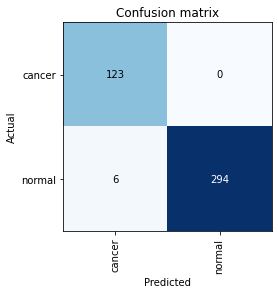

In [62]:
# Run on Mammogram data
predictions_all_mam = []
filenames_mam = []

def get_predictions(path, model):
    image_paths = [os.path.join(path,f) for f in os.listdir(path)]
    predictions = [model.predict_image(img) for img in image_paths]
 
    return image_paths, predictions


train_path = f'data/Mammograms/fastAI/train'
test_path = f'data/Mammograms/fastAI/test/'
print(train_path)
    
model = models.FastAI(train_path)
print(model.path, model.classes)
    
model.verify_images(500)
model.fit(f'fastai_MLO_CC')    
    
# Val Metrics
model.confusion_matrix()
    
# Test predictions
image_paths, predictions = get_predictions(test_path, model)
predictions_all_mam.append(np.array(predictions))
filenames_mam.append(image_paths)



In [21]:
path = Path('data/Histology/40X/train_fastAI')
model = models.FastAI(path)
model.path, model.classes

(PosixPath('data/Histology/40X/train_fastAI'), ['benign', 'malignant'])

In [22]:
model.verify_images(500)

benign


malignant


'done'

In [23]:
learner = model.fit('fastai-test')

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

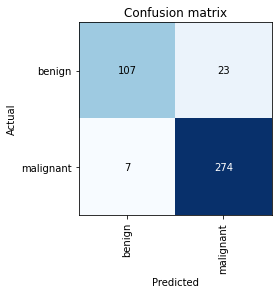

In [43]:
model.confusion_matrix()

In [47]:
model.predict_image('data/Histology/100X/test/test/SOB_M_DC-14-2980-100-006.png')

(['benign', 'malignant'],
 (Category tensor(1), tensor(1), tensor([3.9634e-04, 9.9960e-01])))

In [50]:
model.learning_rate()

AttributeError: 'Learner' object has no attribute 'lrs'

## The long way

In [3]:
path = Path('data/Histology/100X/train_fastAI')

In [4]:
# Go through folder, resize anything larger than 500 pix
for folder in ['benign', 'malignant']:
    print(folder)
    verify_images(path/folder, delete=True, max_size=500)

benign


malignant


['benign', 'malignant']


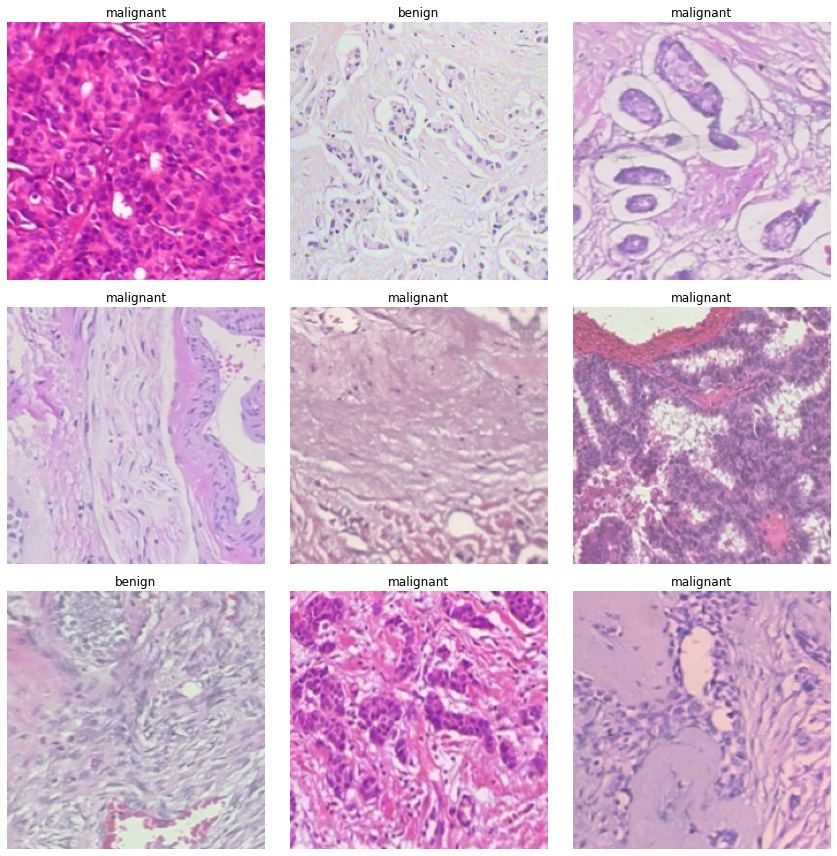

In [5]:
# Set up validation percent
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224, 
                                  num_workers=4).normalize(imagenet_stats)
# Check things
print(data.classes)
data.show_batch(rows=3)

In [ ]:
## Start training
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

# Fit some data
defaults.device = torch.device('cpu')
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,error_rate,time


In [33]:
# Save things and find learning rate
#learn.save('histology_100x_v1')
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


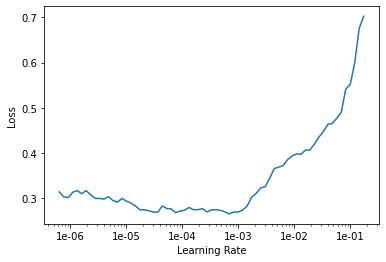

In [38]:
# Plot learning rate
learn.recorder.plot()

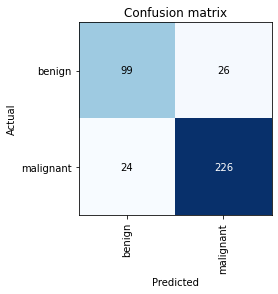

In [7]:
# Confusion matrix on validation set
metric = ClassificationInterpretation.from_learner(learn)
metric.plot_confusion_matrix()

In [14]:
# Predict single image by turning it into ItemBase and putting into predict function
path = 'data/Histology/100X/test/test/SOB_M_MC-14-13413-100-025.png'
image = open_image(path)
#data = ItemBase(path)
learn.predict(image)

(Category tensor(1), tensor(1), tensor([0.0043, 0.9957]))

In [17]:
# Visual interpreter
from fastai.vision.interpret import SegmentationInterpretation
interp = SegmentationInterpretation.from_learner(learn)

IndexError: too many indices for array

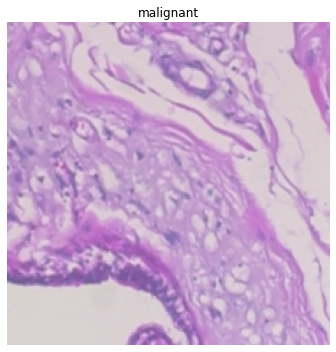

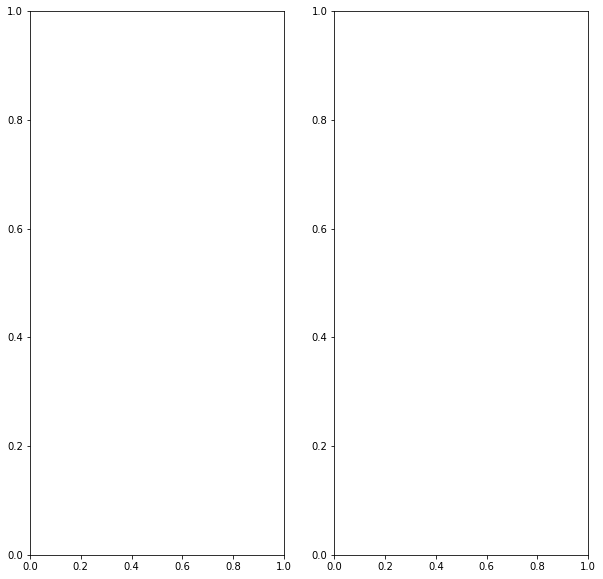

In [21]:
interp.show_xyz(0)